In [ ]:
# execute this to get the file list
# !aws s3 ls --no-sign-request --recursive s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ > output.txt

In [16]:
import sys,os, boto3,glob,shutil 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from botocore import UNSIGNED
from botocore.config import Config

sys.path.append("C:/projects/OpenVisus/build/RelWithDebInfo")
sys.path.append("C:/projects/openvisuspy/src")

import OpenVisus as ov
import openvisuspy
from openvisuspy.create_streamable import Streamable

def DownloadObject(src,dst, endpoint_url=None):
    if os.path.isfile(dst): return
    print(f"DownloadObject {src} -> {dst}")
    assert(src.startswith("s3://"))
    session = boto3.session.Session()
    s3_client = session.client(service_name='s3', config=Config(signature_version=UNSIGNED))
    __bucket,__name=src[len("s3://"):].split("/",maxsplit=1)
    os.makedirs(os.path.dirname(dst),exist_ok=True)
    s3_client.download_file(__bucket,__name, dst) 

def ShowImage(img):
    fig, ax = plt.subplots(figsize=(8, 8))
    pos=ax.imshow(np.flip(img,axis=0), cmap="viridis")
    fig.colorbar(pos, ax=ax,location='right')
    plt.autoscale(True)
    plt.show()

tot=0
files=[]
with open("output.txt","r") as fin:
  for line in fin.readlines():
    if not line: continue
    date,time,size,url=line.split()

    ext=os.path.splitext(url)[1]
    if ext!=".nc":
      continue
    
    files.append({
      "date":date,
      "time":time,
      "size":int(size),
      "url":f"s3://nex-gddp-cmip6/{url}" # add the bucket name
    })

num_files=len(files)
total_size=sum([it['size'] for it in files])
print(f"num_files={num_files:,} total_size={total_size:,}")

num_files=161,582 total_size=41,698,037,516,487


In [17]:
for I,it in enumerate(files):

  url=it['url']
  id=os.path.splitext(os.path.basename(url))[0]

  tmp_directory=f"./remove-me/{id}"

  DownloadObject(
    url, 
    f"{tmp_directory}/full.nc")

  # need to remove the year 
  #   NEX-GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc
  #   NEX-GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1954_v1.1.nc
  if True:
    v=id.split("_")
    version=v.pop(-1) if v[-1][0]=="v" else None
    year=int(v.pop(-1))
    if version: v.append(version)
    field,day_,model, scenario, r_, g_=v
    field="_".join(v)
    timestep=year*365
    break

Streamable.Create(
  f"{tmp_directory}/full.nc",
  f"{tmp_directory}/streamable.h5", 
  arco="2mb", 
  compression="zip", 
  timestep=timestep,
  field=field,
  idx_urls={
    "default": "remote",
    "local":  f"{tmp_directory}/visus.idx", 
    "remote": "https://maritime.sealstorage.io/api/v0/s3/utah/nex-gddp-cmip6/visus.idx?cached=arco&access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
  }
)



DANGEROUS but needed: removing any old data file from ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus
Read data in 3.5754446983337402 seconds shape=(365, 600, 1440) dtype=float32 vmin=-58.72854232788086 vmax=1.0000000200408773e+20
Created IDX idx_url=[./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx] idx_axis=[X Y Z] idx_physic_box=[0 1440 0 600 0 365]
175015924 DiskAccess:111 37256:4872 DiskAccess using existing IdxFile at ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx
175015924 DiskAccess:140 37256:4872 Created DiskAccess local_idx_filename ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx filename_template c:/projects/openvisuspy/./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus/$(time)/$(field)/$(block:%016x:%04x).bin compression bDisableWriteLocks False
Wrote IDX data in 1.7507247924804688 seconds
Compressing dataset compression=zip...
175017675 DiskAccess:111 37256:4872 DiskAccess us

175027154 DiskAccess:111 37256:4872 DiskAccess using existing IdxFile at ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx
175027154 DiskAccess:140 37256:4872 Created DiskAccess local_idx_filename ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx filename_template c:/projects/openvisuspy/./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus/$(time)/$(field)/$(block:%016x:%04x).bin compression bDisableWriteLocks False


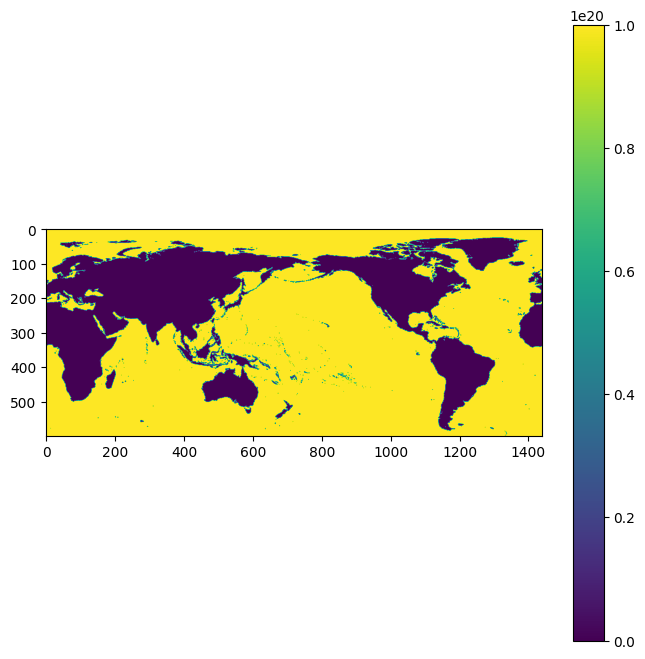

In [18]:
db=ov.LoadDataset(f"{tmp_directory}/visus.idx")
data=db.read(z=[100,101])[0,:,:] # defaults unnecessary time=711750,field="hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn")
ShowImage(data)

# The streamable is ok

In [22]:
Streamable.Print(f"{tmp_directory}/streamable.h5")

 /
   @Conventions=b'CF-1.7'
   @_NCProperties=b'version=1|netcdflibversion=4.4.1.1|hdf5libversion=1.10.1'
   @_nc3_strict=1
   @activity=b'NEX-GDDP-CMIP6'
   @cmip6_institution_id=b'CSIRO-ARCCSS'
   @cmip6_license=b'CC-BY-SA 4.0'
   @cmip6_source_id=b'ACCESS-CM2'
   @contact=b'Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget Thrasher: bridget@climateanalyticsgroup.org'
   @creation_date=b'2021-10-04T13:59:21.654137+00:00'
   @disclaimer=b'This data is considered provisional and subject to change. This data is provided as is without any warranty of any kind, either express or implied, arising by law or otherwise, including but not limited to warranties of completeness, non-infringement, accuracy, merchantability, or fitness for a particular purpose. The user assumes all risk associated with the use of, or inability to use, this data.'
   @external_variables=b'areacella'
   @frequency=b'day'
   @history=b'2021-10-04T13:59:21.654137+00:00: install global attributes'
   @idx_url=https:/

In [23]:
# Show the data

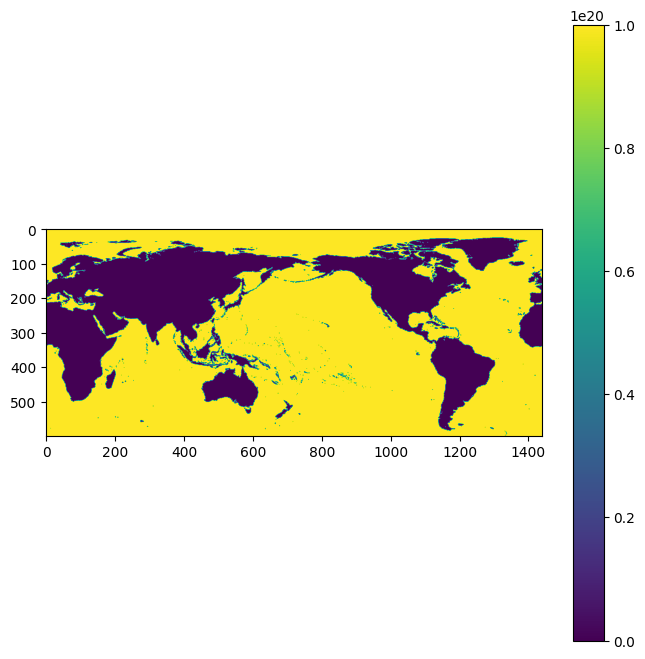

In [26]:
import xarray as xr
ds = xr.open_dataset(f"{tmp_directory}/full.nc", group="/", mask_and_scale=False) # group="hours"
Z=100
ShowImage(ds["hurs"][Z,...])

# BROKEN

There is something in the h5 that must tell to xarray it is a netcdf4

In [21]:
from openvisuspy.xarray_backend import OpenVisusBackendEntrypoint

ds = xr.open_dataset(
    f"{tmp_directory}/streamable.h5", 
    engine=OpenVisusBackendEntrypoint, 
    prefer="local"
)

if False:
    field=ds[fieldname]
    timestep,res=0,27
    data=field[timestep,...,res].values
    print("Got data","type",type(data),"shape",data.shape,"dtype",data.dtype,"min",np.min(data),"max",np.max(data))

    Z=100
    slice=data[Z,...]
    ShowImage(slice)

OSError: [Errno -101] NetCDF: HDF error: 'c:\\projects\\openvisuspy\\remove-me\\hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950\\streamable.h5'